# Raw Analytics - US Real Estate
### Analise de qualidade dos dados brutos da camada raw

Dados obtidos a partir de um dataset publico disponibilizado pelo Kaggle: [USA Real Estate Dataset](https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset/data)

## 1. Data Loading

In [1]:
import pandas as pd
import pyspark.sql as psql
from pyspark.sql import SparkSession

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

RAW_DATA = "./us-realestate-data.csv"

In [2]:
# Criação da SparkSession e do Schema do Dataset

spark = SparkSession.builder.appName("raw_analytics").getOrCreate()

# No schema inicial todos tem permissão para serem nulos na intenção de evitar mudanças no dado bruto

schema = psql.types.StructType([
    psql.types.StructField("brokered_by", psql.types.FloatType(), True),
    psql.types.StructField("status", psql.types.StringType(), True),
    psql.types.StructField("price", psql.types.FloatType(), True),
    psql.types.StructField("bed", psql.types.IntegerType(), True),
    psql.types.StructField("bath", psql.types.IntegerType(), True),
    psql.types.StructField("acre_lot", psql.types.FloatType(), True),
    psql.types.StructField("street", psql.types.FloatType(), True),
    psql.types.StructField("city", psql.types.StringType(), True),
    psql.types.StructField("state", psql.types.StringType(), True),
    psql.types.StructField("zip_code", psql.types.StringType(), True),
    psql.types.StructField("house_size", psql.types.FloatType(), True),
    psql.types.StructField("prev_sold_date", psql.types.DateType(), True)
])

df = spark.read.csv(RAW_DATA, header=True, schema=schema)

## 2. Data Analysis

Esse capítulo esta divido em dois tópicos:

1. Integridade Técnica: tem como objetivo de analisar os dados sem entrar no que eles representam
2. Contextualização: tem como objetivo analisar o contexto por traz dos dados

Vale lembrar que o dataset foi originado a partir de um algoritmo de webscraping que não foi disponibilizado publicamente. O autor obteve as informações do site [Realtor.com](https://www.realtor.com)

### 2.1 Integridade Técnica

O objetivo desse primeiro tópico é analisar os dados em sua forma mais pura: avaliar sua integridade e conteúdo sem levar em conta o contexto por trás deles. Isso significa analisa-los de forma isolada, sem considerar seu contexto ou significado. A finalidade é examinar sua estrutura, consistência e qualidade intrínseca antes de qualquer interpretação.

In [3]:
df.count()

2226382

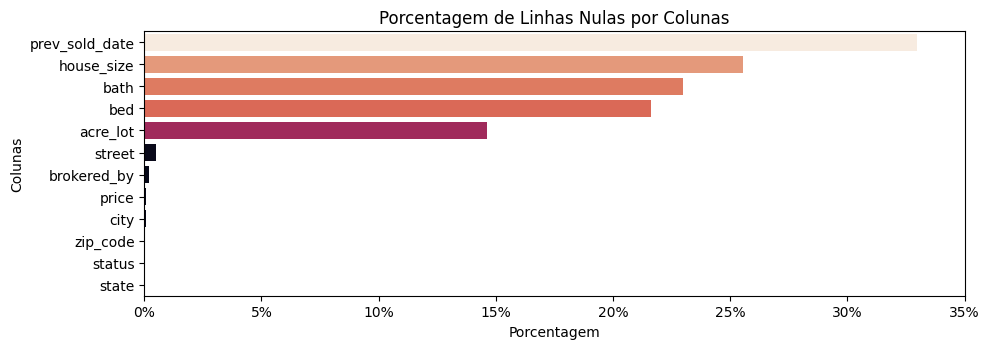

In [4]:
total = df.count()
colunas = df.columns
data = []

for coluna in colunas:
    nulos = df.filter(psql.functions.col(coluna).isNull()).count()
    porcentagem = round((nulos * 100) / total, 2)
    data.append((coluna, nulos, porcentagem))

aux = pd.DataFrame(data, columns=["colunas", "qntd_null", "%"])
aux = aux.sort_values("%", ascending=False)

plt.figure(figsize=(10, len(aux)*0.3))
sns.barplot(data=aux, y='colunas', x='%', hue='%', palette='rocket', legend=False)

ax = plt.gca()
tick_locations = ax.get_xticks()
ax.set_xticks(tick_locations)
ax.set_xticklabels([f'{x:.0f}%' for x in tick_locations])

plt.xlabel('Porcentagem')
plt.ylabel('Colunas')
plt.title('Porcentagem de Linhas Nulas por Colunas')
plt.tight_layout()
plt.show()

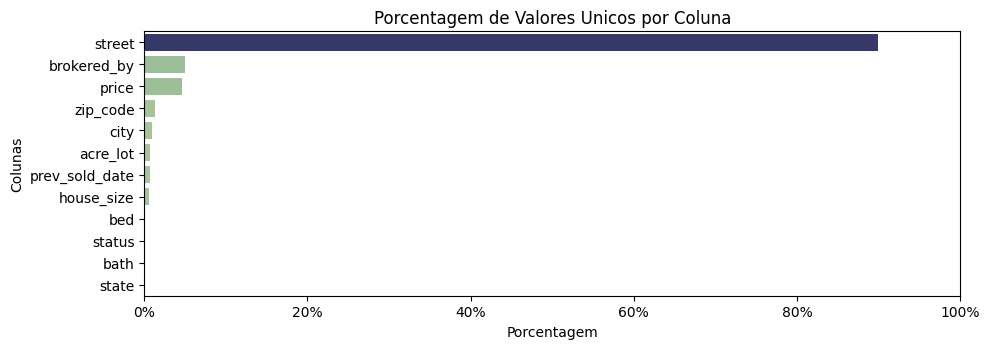

In [5]:
data = []

for coluna in colunas:
    unicos = df.select(coluna).distinct().count()
    porcentagem = round((unicos * 100) / total, 2)
    data.append((coluna, unicos, porcentagem))

aux = pd.DataFrame(data, columns=["colunas", "qntd_unicos", "%"])
aux = aux.sort_values("%", ascending=False)

plt.figure(figsize=(10, len(aux)*0.3))
sns.barplot(data=aux, y='colunas', x='%', hue='%', palette='crest', legend=False)

ax = plt.gca()
tick_locations = ax.get_xticks()
ax.set_xticks(tick_locations)
ax.set_xticklabels([f'{x:.0f}%' for x in tick_locations])

plt.xlabel('Porcentagem')
plt.ylabel('Colunas')
plt.title('Porcentagem de Valores Unicos por Coluna')
plt.tight_layout()
plt.show()

In [6]:
data = []
cols = ["price", "acre_lot", "house_size", "bed", "bath"]
tt = df.select("price", "acre_lot", "house_size", "bed", "bath")

for coluna in cols:
    minimo = tt.select(psql.functions.min(coluna)).collect()[0][0]
    maximo = tt.select(psql.functions.max(coluna)).collect()[0][0]
    avg = tt.select(psql.functions.avg(coluna)).collect()[0][0]
    desvio = tt.select(psql.functions.stddev(coluna)).collect()[0][0]
    data.append((coluna, minimo, maximo, avg, desvio))

df_pd = pd.DataFrame(data, columns=["colunas", "min", "max", "avg", "desvio"])
pd.options.display.float_format = '{:.0f}'.format
df_pd.head(15)

,colunas,min,max,avg,desvio
0,price,0,2147483648,524196,2138893
1,acre_lot,0,100000,15,763
2,house_size,4,1040400384,2714,808164
3,bed,1,473,3,2
4,bath,1,830,2,2


### Considerações

Com base na análise de integridade técnica realizada, observa-se que o conjunto de dados apresenta inconsistências que podem se tornar mais ou menos relevantes dependendo do contexto e das regras de negócio aplicadas posteriormente.

Os gráficos indicam que determinadas colunas possuem deficiências significativas em sua completude, evidenciadas pela alta proporção de valores ausentes. Além disso, algumas delas apresentam baixa cardinalidade, ou seja, um número limitado de valores únicos, o que pode comprometer sua utilidade analítica.

Do ponto de vista estrutural, trata-se de um dataset robusto, composto por mais de 2 milhões de registros e 12 colunas. Apenas cinco dessas colunas apresentam percentuais relevantes de valores nulos, o que sugere uma boa densidade de informações na maior parte dos campos.

Contudo, a tabela de estatísticas descritivas revela a presença de desvios padrão elevados em algumas variáveis numéricas. A relevância dessas variações só poderá ser adequadamente avaliada em etapas subsequentes, quando o contexto e os objetivos analíticos forem considerados.

## 2.2 Analise Contextual

O objetivo deste tópico é realizar a análise contextual dos dados, superando a etapa de verificação intrínseca. Aqui, os dados serão examinados à luz do seu significado, domínio de aplicação e das regras de negócio pertinentes.

In [7]:
# preco, frequencia | house_size, frequencia | acre_lot, frequencia | bed, frequencia x bath, frequencia
f_price = df.groupBy("price").agg(psql.functions.count("price").alias("price_freq")).toPandas()
f_hs = df.groupBy("house_size").agg(psql.functions.count("house_size").alias("hs_freq")).toPandas()
f_al = df.groupBy("acre_lot").agg(psql.functions.count("acre_lot").alias("al_freq")).toPandas()

f_bed = df.groupBy("bed").agg(psql.functions.count("bed").alias("bed_freq"))
f_bath = df.groupBy("bath").agg(psql.functions.count("bath").alias("bath_freq"))
bedbath = f_bed.join(f_bath, f_bed.bed == f_bath.bath, "inner").sort(psql.functions.desc(f_bed.bed)).toPandas()


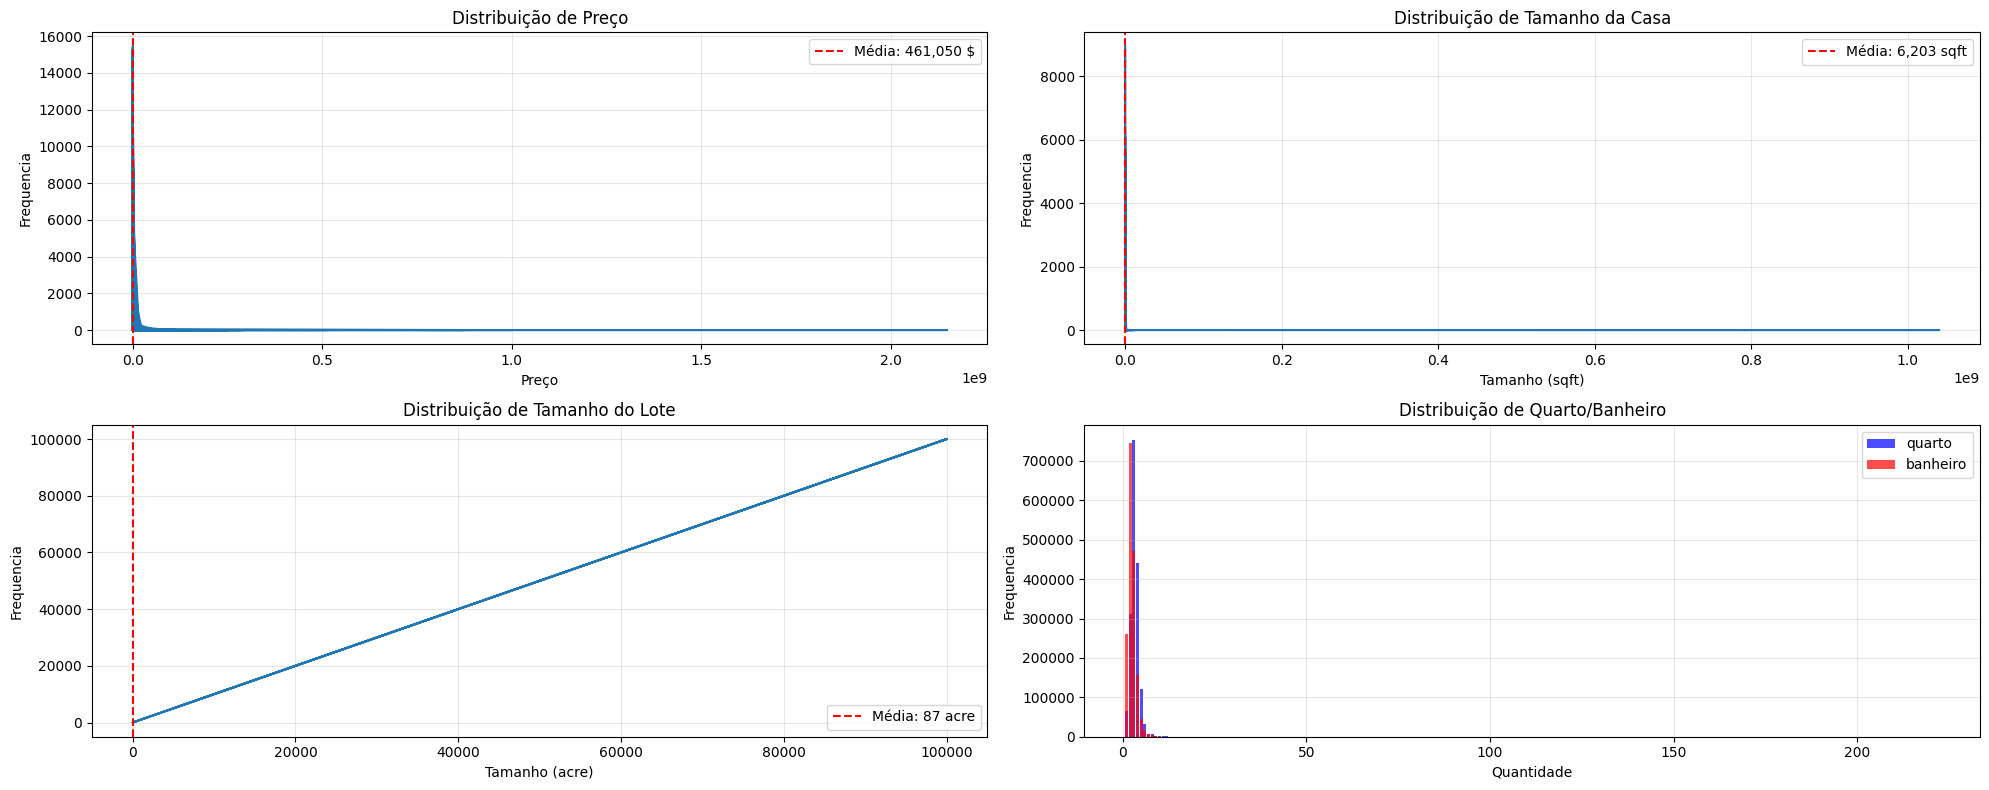

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(20, 8))

# Grafico de preço x frequencia

axs[0, 0].plot(f_price['price'], f_price['price_freq'])
axs[0, 0].axvline(f_price['price'].median(), color='r', linestyle='--', label=f'Média: {f_price["price"].median():,.0f} $')

axs[0, 0].set_title('Distribuição de Preço')
axs[0, 0].set_xlabel('Preço')
axs[0, 0].set_ylabel('Frequencia')
axs[0, 0].legend()
axs[0, 0].grid(True, alpha=0.3)

# Grafico de house_size x frequencia

axs[0, 1].plot(f_hs['house_size'], f_hs['hs_freq'])
axs[0, 1].axvline(f_hs['house_size'].median(), color='r', linestyle='--', label=f'Média: {f_hs["house_size"].median():,.0f} sqft')

axs[0, 1].set_title('Distribuição de Tamanho da Casa')
axs[0, 1].set_xlabel('Tamanho (sqft)')
axs[0, 1].set_ylabel('Frequencia')
axs[0, 1].legend()
axs[0, 1].grid(True, alpha=0.3)

# Grafico de acre_lot x frequencia

axs[1, 0].plot(f_al['acre_lot'], f_al['acre_lot'])
axs[1, 0].axvline(f_al['acre_lot'].median(), color='r', linestyle='--', label=f'Média: {f_al["acre_lot"].median():,.0f} acre')

axs[1, 0].set_title('Distribuição de Tamanho do Lote')
axs[1, 0].set_xlabel('Tamanho (acre)')
axs[1, 0].set_ylabel('Frequencia')
axs[1, 0].legend()
axs[1, 0].grid(True, alpha=0.3)

# Grafico de bed+bath x frequencia
axs[1, 1].bar(bedbath['bed'], bedbath['bed_freq'], label='quarto', alpha=0.7, color='blue')
axs[1, 1].bar(bedbath['bath'], bedbath['bath_freq'], label='banheiro', alpha=0.7, color='red')

axs[1, 1].set_title('Distribuição de Quarto/Banheiro')
axs[1, 1].set_xlabel('Quantidade')
axs[1, 1].set_ylabel('Frequencia')
axs[1, 1].legend()
axs[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


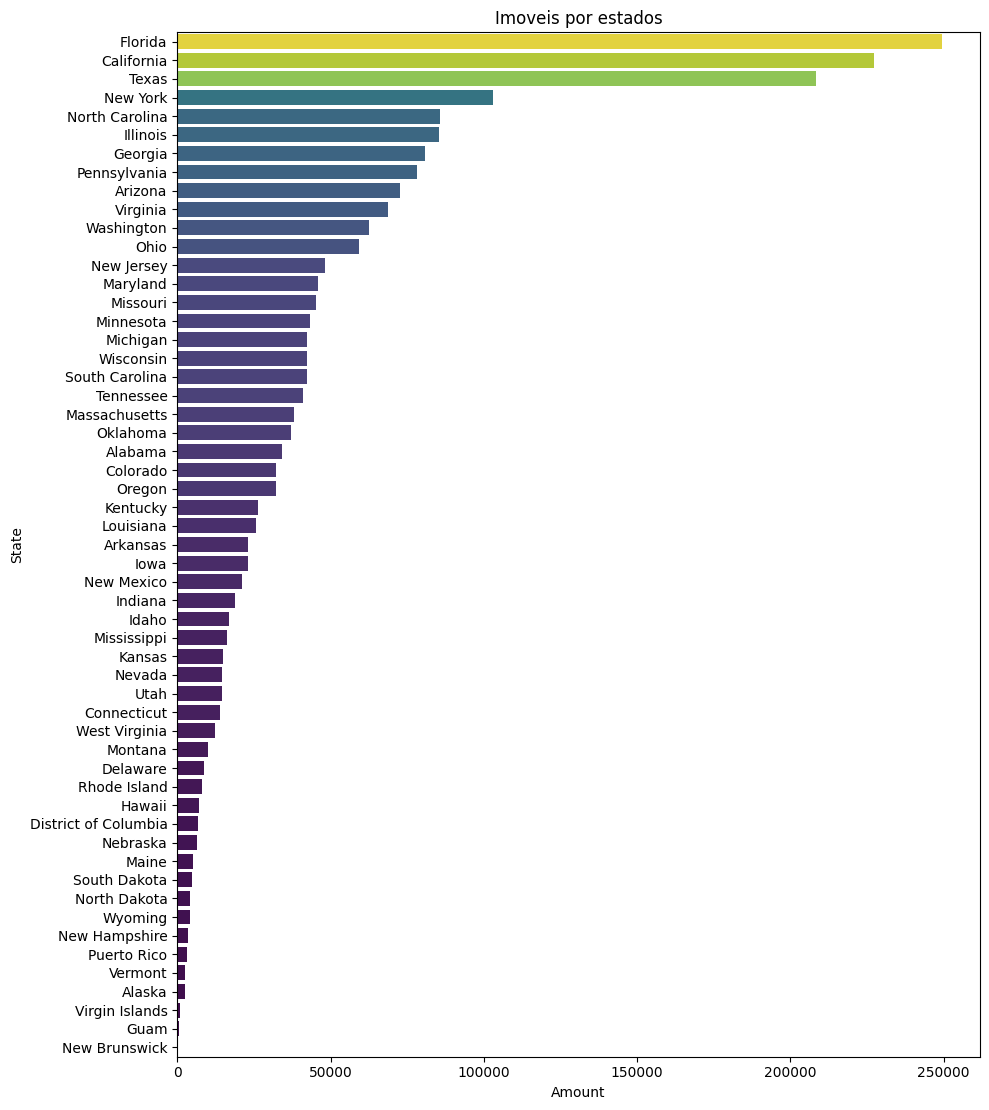

In [11]:
aux = df.select("state").groupBy("state").agg(psql.functions.count("state").alias("amount")).orderBy("amount", ascending=False).toPandas()

plt.figure(figsize=(10, len(aux)*0.2))
sns.barplot(data=aux, y='state', x='amount', hue='amount', palette='viridis', legend=False)
plt.xlabel('Amount')
plt.ylabel('State')
plt.title('Imoveis por estados')
plt.tight_layout()
plt.show()

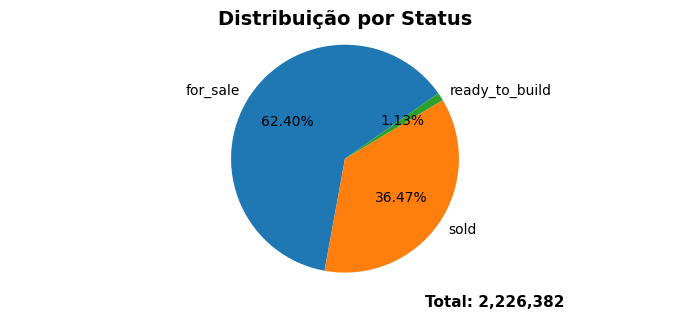

In [12]:
aux = (
    df.groupBy("status")
    .agg(psql.functions.count("status")
    .alias("qntd"))
    .withColumn("%", psql.functions.round(psql.functions.col("qntd") / total * 100, 2))
    .orderBy("%", ascending=False)
)

aux = aux.toPandas()

plt.figure(figsize=(10, 8))

plt.pie(aux['%'].values, labels=aux['status'].values, autopct='%1.2f%%', startangle=35)
plt.title(f'Distribuição por Status', fontsize=14, fontweight='bold')
plt.axis('equal')

plt.figtext(0.5, 0.01, f'Total: {aux["qntd"].sum():,}', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout(rect=[0, 0.02, 0.7, 0.4])
plt.show()


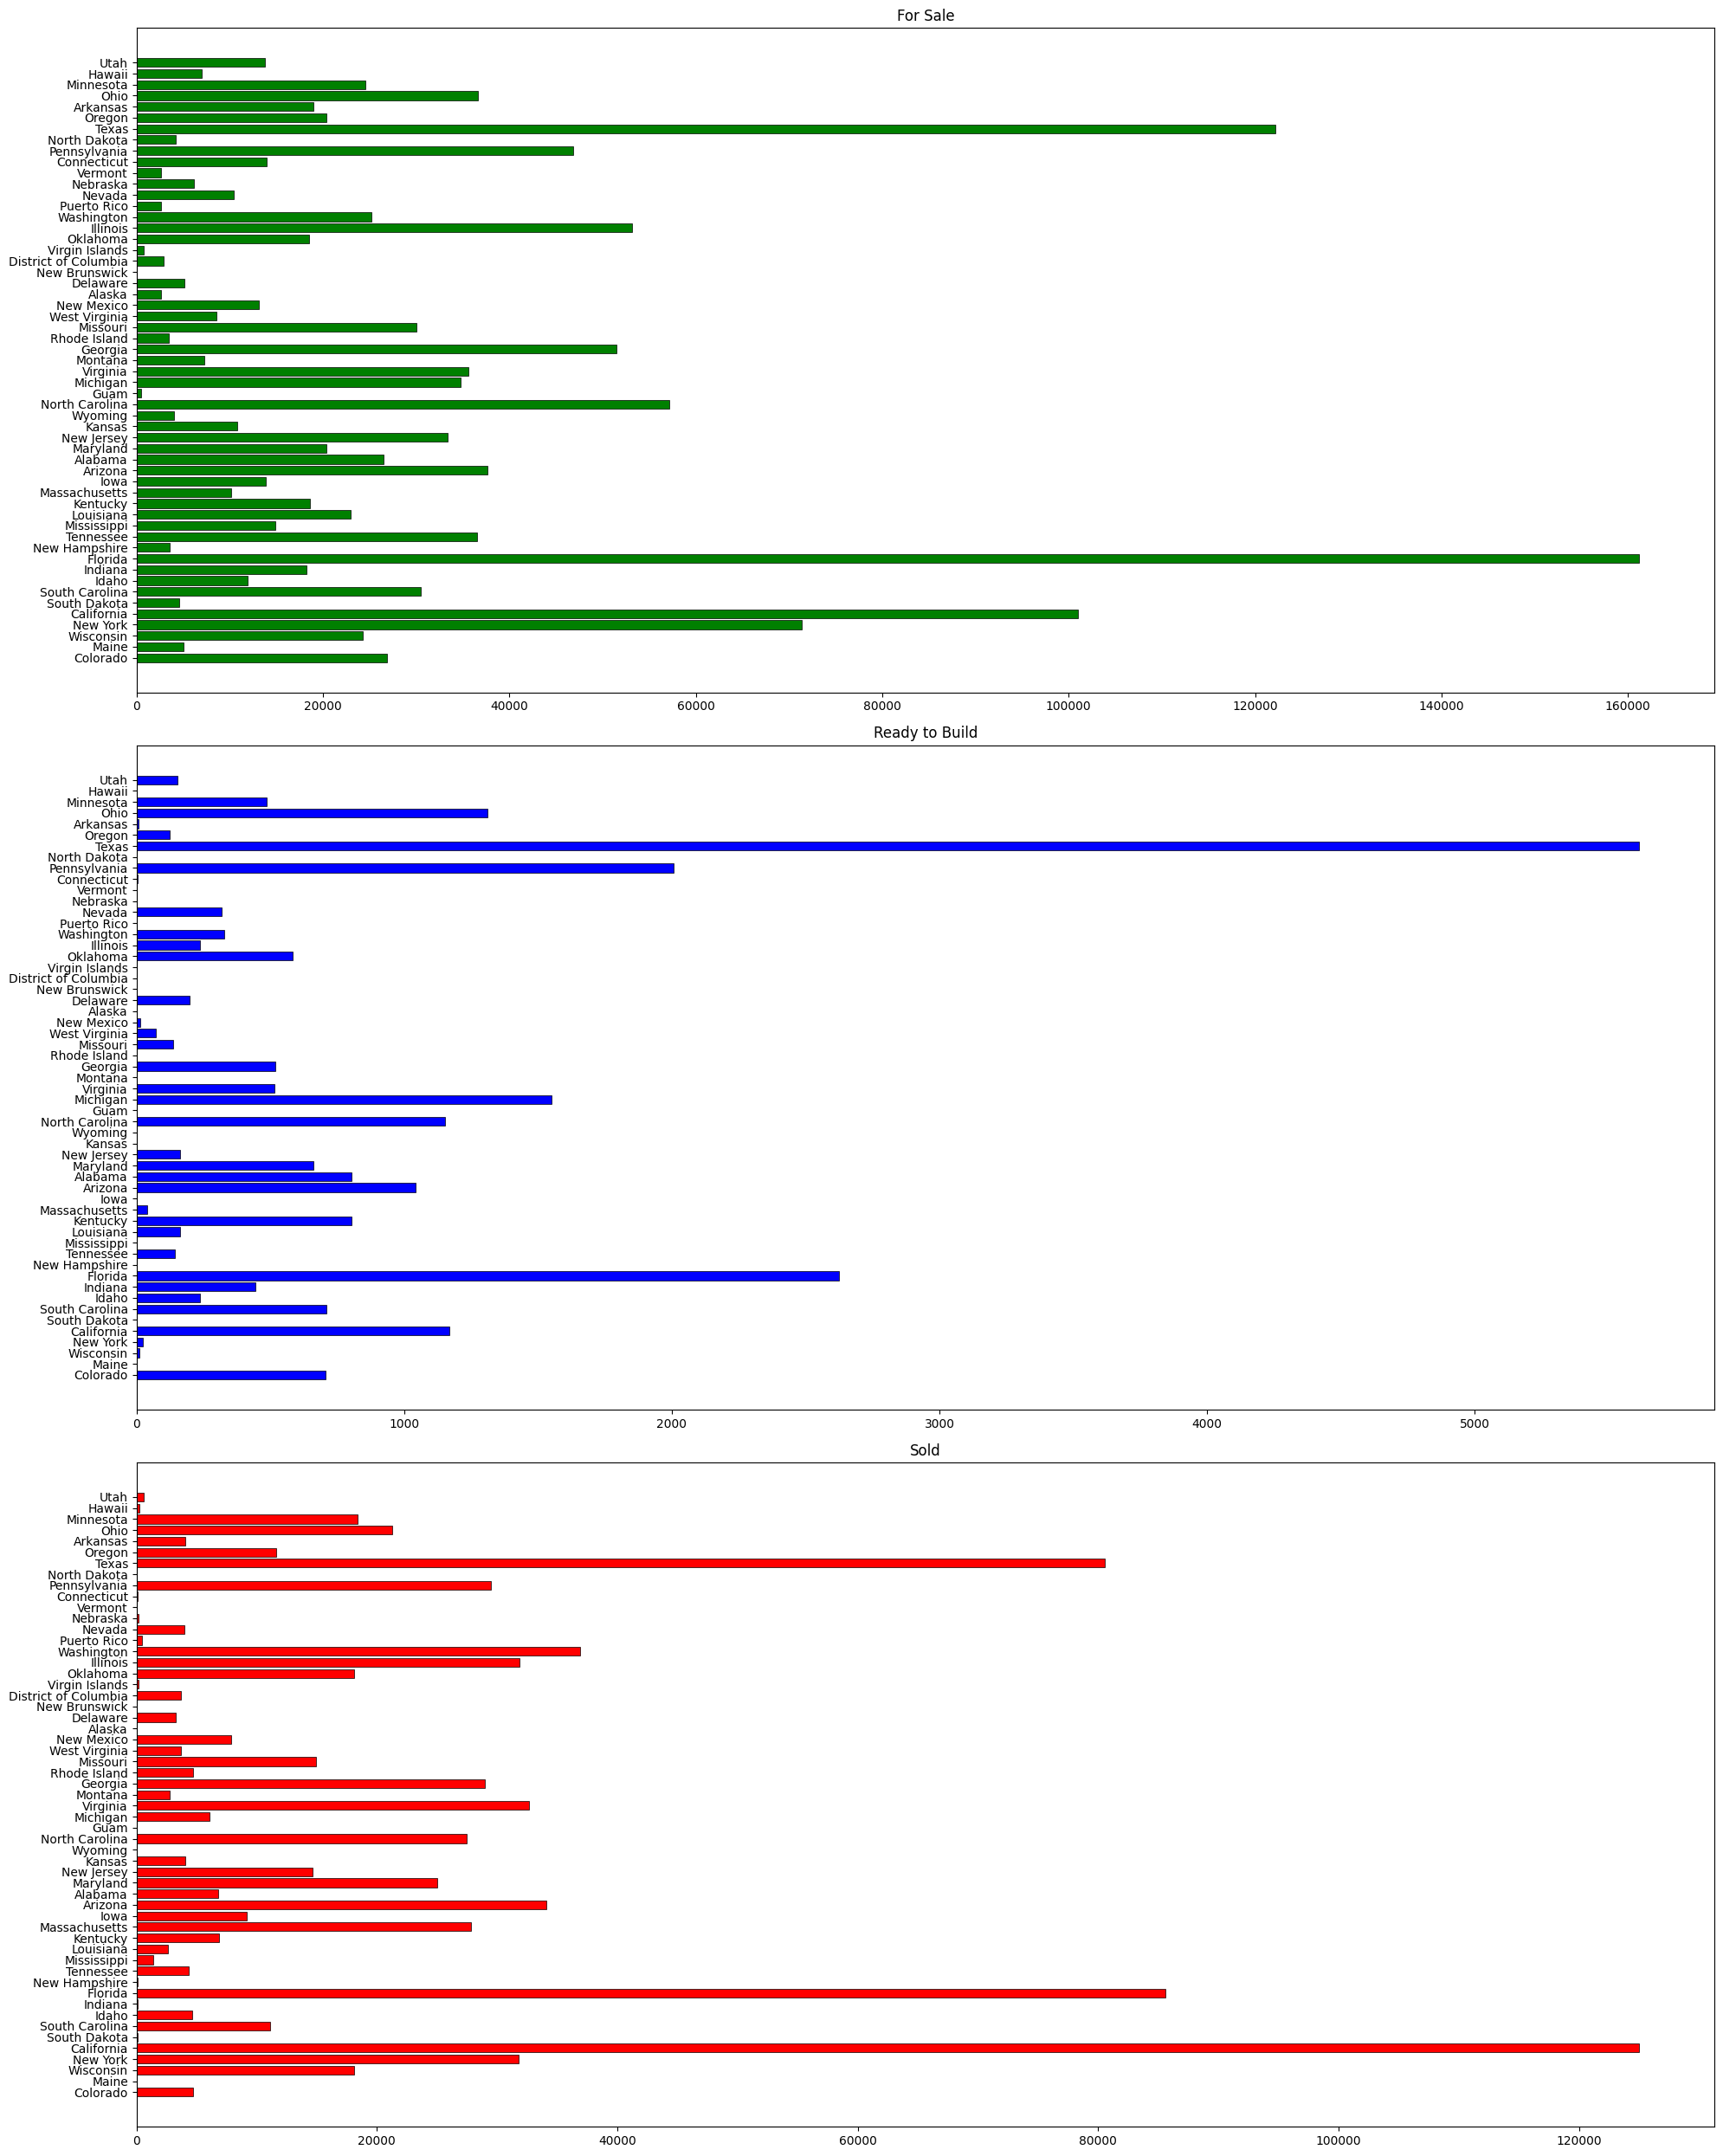

In [13]:
aux = df.withColumn('aux', psql.functions.lit(1))

pivot_df = (aux.filter(psql.functions.col('state').isNotNull() & psql.functions.col('status').isNotNull())
    .groupBy('state')
    .pivot('status', ['for_sale', 'ready_to_build', 'sold'])
    .agg(psql.functions.sum('aux').alias('count'))
    .fillna(0))

fig, axs = plt.subplots(3, 1, figsize=(20, 25))

pd_pivot_df = pivot_df.toPandas()

axs[0].barh(pd_pivot_df['state'], pd_pivot_df['for_sale'], 
               edgecolor='black', linewidth=0.5, color='green')
axs[1].barh(pd_pivot_df['state'], pd_pivot_df['ready_to_build'], 
               edgecolor='black', linewidth=0.5, color='blue')
axs[2].barh(pd_pivot_df['state'], pd_pivot_df['sold'], 
               edgecolor='black', linewidth=0.5, color='red')

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()

axs[0].set_title('For Sale')
axs[1].set_title('Ready to Build')
axs[2].set_title('Sold')

plt.tight_layout()
plt.show()

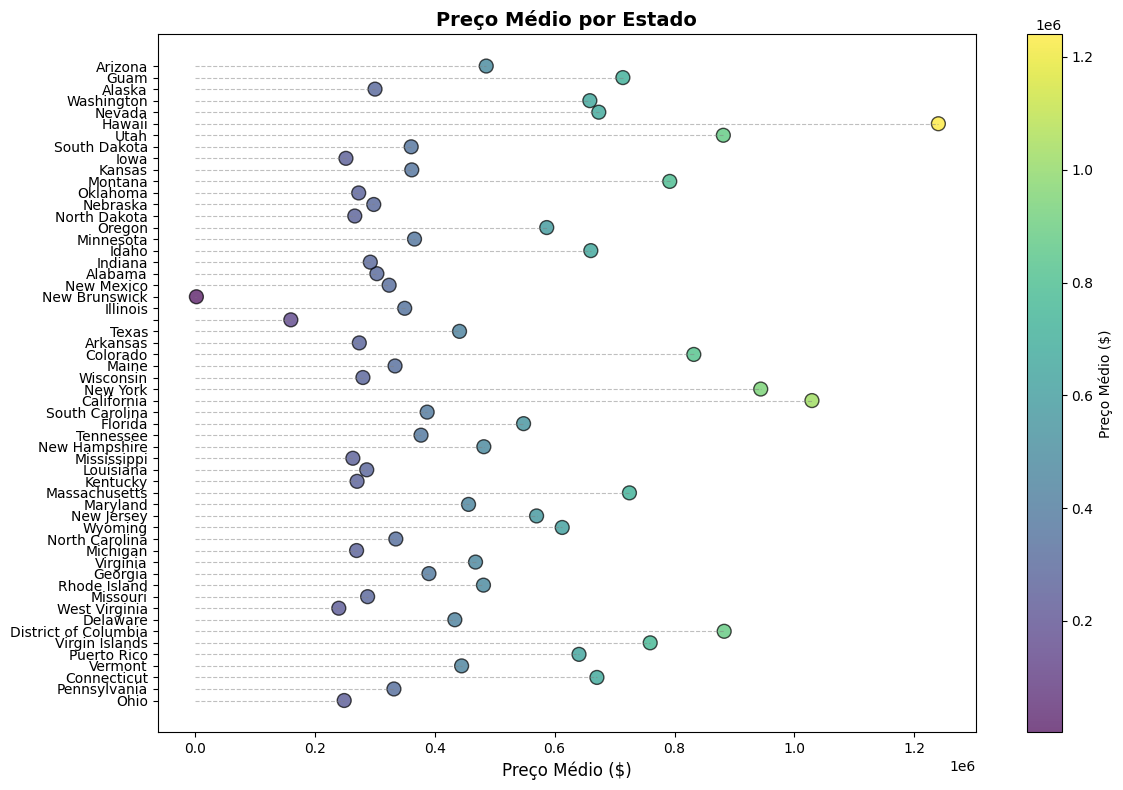

In [16]:
aux = df.groupBy('state').agg(psql.functions.round(psql.functions.avg('price'), 2).alias('price_media')).toPandas()

fig, ax = plt.subplots(figsize=(12, 8))

state_to_num = {state: i for i, state in enumerate(aux['state'])}
aux['state_num'] = aux['state'].map(state_to_num)

scatter = ax.scatter(aux['price_media'], aux['state_num'], 
                     c=aux['price_media'], 
                     cmap='viridis', 
                     s=100,
                     alpha=0.7,
                     edgecolors='black')

for price, y in zip(aux['price_media'], aux['state_num']):
    ax.hlines(y=y, xmin=0, xmax=price, 
              colors='gray', linestyles='dashed', alpha=0.5, linewidth=0.8)

ax.set_yticks(range(len(aux['state'])))
ax.set_yticklabels(aux['state'])
ax.set_xlabel('Preço Médio ($)', fontsize=12)
ax.set_title('Preço Médio por Estado', fontsize=14, fontweight='bold')

plt.colorbar(scatter, label='Preço Médio ($)')

plt.tight_layout()
plt.show()


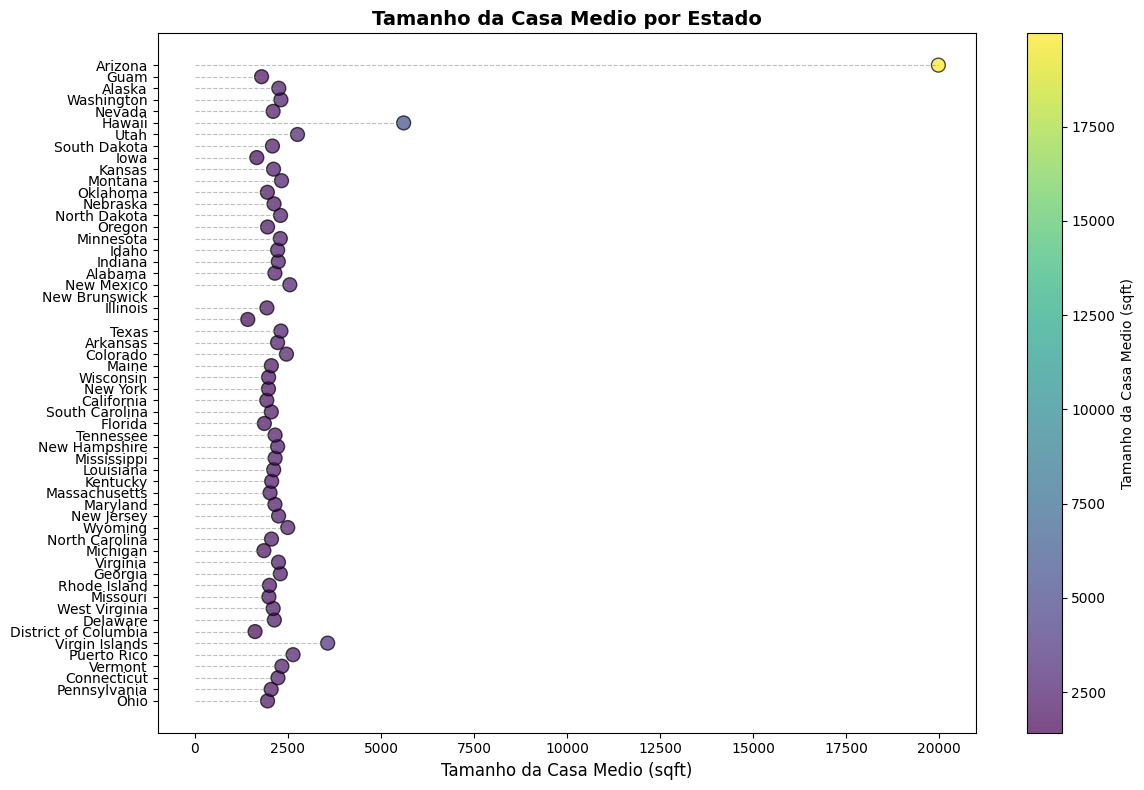

In [17]:
aux = df.groupBy('state').agg(psql.functions.round(psql.functions.avg('house_size'), 2).alias('hs_media')).toPandas()

fig, ax = plt.subplots(figsize=(12, 8))

state_to_num = {state: i for i, state in enumerate(aux['state'])}
aux['state_num'] = aux['state'].map(state_to_num)

# Scatter plot com colormap válido
scatter = ax.scatter(aux['hs_media'], aux['state_num'], 
                     c=aux['hs_media'], 
                     cmap='viridis', 
                     s=100,
                     alpha=0.7,
                     edgecolors='black')

for price, y in zip(aux['hs_media'], aux['state_num']):
    ax.hlines(y=y, xmin=0, xmax=price, 
              colors='gray', linestyles='dashed', alpha=0.5, linewidth=0.8)

ax.set_yticks(range(len(aux['state'])))
ax.set_yticklabels(aux['state'])
ax.set_xlabel('Tamanho da Casa Medio (sqft)', fontsize=12)
ax.set_title('Tamanho da Casa Medio por Estado', fontsize=14, fontweight='bold')

plt.colorbar(scatter, label='Tamanho da Casa Medio (sqft)')

plt.tight_layout()
plt.show()


In [26]:
aux = df.withColumn('price_per_sqft', psql.functions.round(psql.functions.col('price') / psql.functions.col('house_size'), 2))
aux = (aux.groupBy('state')
    .agg(
        psql.functions.min('price_per_sqft').alias('min'), 
        psql.functions.max('price_per_sqft').alias('max'), 
        psql.functions.round(psql.functions.avg('price_per_sqft'), 2).alias('media'),
        psql.functions.round(psql.functions.stddev('price_per_sqft'), 2).alias('desvio'))
    .orderBy('desvio', ascending=False)
).show(60)


+--------------------+------+---------+------+-------+
|               state|   min|      max| media| desvio|
+--------------------+------+---------+------+-------+
|          California|   0.0|2426535.2| 545.8|5589.87|
|            New York|   0.0| 462500.0|487.17|2263.46|
|              Hawaii|   0.0| 11270.49|813.31| 670.15|
|            Colorado|   0.0| 45787.55|365.78| 568.38|
|             Montana|  0.02|  14877.1|369.37| 520.52|
|             Wyoming| 11.45| 11645.96| 291.8| 469.24|
|               Idaho|   0.0| 17535.56|305.64| 352.32|
|         Puerto Rico|  5.69|  4595.72|231.88| 331.62|
|             Florida|  0.08|  25900.0|308.04| 324.42|
|       Massachusetts|  3.05| 15015.02|383.88|  314.7|
|              Oregon|   0.0| 22951.98| 318.4| 282.54|
|                Utah|  12.0|  3402.68| 335.8| 280.24|
|               Maine|  8.74|  3337.38|262.39| 257.59|
|        South Dakota|   0.0|  7628.75|205.82| 253.22|
|         Connecticut| 11.61|  7629.51|269.32|  247.7|
|         

In [38]:
aux = (df.filter((psql.functions.col('acre_lot') > 0.0) & (psql.functions.col('price') > 0.0))
    .withColumn('price_per_acre', psql.functions.round(psql.functions.col('price') / psql.functions.col('acre_lot'), 2)))
aux = (aux.groupBy('state')
    .agg(
        psql.functions.min('price_per_acre').alias('min'), 
        psql.functions.round(psql.functions.max('price_per_acre'), 2).alias('max'), 
        psql.functions.round(psql.functions.avg('price_per_acre'), 2).alias('media'),
        psql.functions.round(psql.functions.stddev('price_per_acre'), 2).alias('desvio'))
    .orderBy('desvio', ascending=False)
)

aux.show(60)


+--------------------+---------+-----------------+-------------+-------------+
|               state|      min|              max|        media|       desvio|
+--------------------+---------+-----------------+-------------+-------------+
|          California|     0.07|1.789569746667E10|   6451548.84|4.098130519E7|
|             Georgia|     0.94|  9.38333354307E9|   1957545.79|3.500329008E7|
|                Utah|      0.0|   9.0000002012E8|   7557819.13|2.217556505E7|
|       West Virginia|     0.01|  2.19999996722E9|    865553.79|2.100579637E7|
|District of Columbia|703125.02|   2.2990000514E8|2.447050306E7|2.035544036E7|
|            New York|     0.11|   1.8300000409E9|   5087784.19| 1.95657091E7|
|         Puerto Rico|      1.1|   1.8950000424E8|   3833248.31|1.123863503E7|
|       Massachusetts|     0.11|   2.7950000625E8|   4121910.32|1.052051483E7|
|            Colorado|    31.15|   4.9750001112E8|   3792975.46|1.006947801E7|
|              Nevada|     50.0|   2.2895000512E8|  

In [47]:
aux = df.withColumn('price_per_sqft', psql.functions.round(psql.functions.col('price') / psql.functions.col('house_size'), 2))
aux = (aux.groupBy('state', 'city').agg(psql.functions.round(psql.functions.avg('price_per_sqft'), 2).alias('media')))

wspec = psql.window.Window.partitionBy('state').orderBy(psql.functions.desc('media'))

top_cities = (aux
    .withColumn('row_num', psql.functions.row_number().over(wspec))
    .filter(psql.functions.col('row_num') == 1)
    .drop('row_num')
    .orderBy(psql.functions.desc('media'))
)

top_cities.show(60)


+--------------------+------------------+---------+
|               state|              city|    media|
+--------------------+------------------+---------+
|          California|     International|2426535.2|
|            New York|            Laurel| 92837.59|
|             Montana|             Olney|  14877.1|
|            Colorado|          Snowmass|   8873.7|
|               Idaho|            Picabo|  8449.07|
|              Oregon|           Chemult|  7947.72|
|        South Dakota|          Parmelee|  7628.75|
|             Georgia|       Bolingbroke|  3351.85|
|               Maine|        Friendship|   3250.0|
|            Michigan|          Gulliver|  3080.77|
|               Texas|          Midfield|  3073.67|
|             Florida|         Manalapan|  2982.29|
|            Nebraska|           Venango|  2929.93|
|              Hawaii|             Poipu|  2829.56|
|             Indiana|          Guilford|  2708.33|
|             Wyoming|            Ucross|  2367.43|
|           